In [9]:
import nibabel as nib
import numpy as np
import torch as t
from scipy.ndimage import zoom
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from DiagnosisAI.datasets_torch.brain_3d_dataset import Brain3DDataset
from DiagnosisAI.utils.metrics import calc_metrics, calculate_type_errors
from DiagnosisAI.models.Unet3D import Unet3d
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from DiagnosisAI.utils.utils_function import get_max_area_slice
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import pandas as pd
from torchmetrics import JaccardIndex
import matplotlib

## 64, 64, 64 SIZE

In [2]:
logs1 = pd.read_csv('/mnt/e/mgr/trainings/logs/seg_binary_3d/resnet34_64_64_64/logs (1).csv')
logs2 = pd.read_csv('/mnt/e/mgr/trainings/logs/seg_binary_3d/resnet34_64_64_64/logs (2).csv')

In [3]:
epochs = np.arange(1, len(logs1.index) + len(logs2.index) + 1)

In [4]:
logs = pd.concat([logs1, logs2], axis=0)
logs['epochs'] = epochs
logs.drop(['Unnamed: 0'], inplace=True, axis=1)
logs.set_index('epochs' ,inplace=True)

In [5]:
logs.columns
metric_cols = ["acc", 'recall', 'prec', 'f1', 'val_recall', 'val_prec', 'val_acc', 'val_f1', 'ji', 'val_ji']
logs[metric_cols] = logs[metric_cols] * 100

Text(0, 0.5, 'Wartość binarnej entropii krzyżowej')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


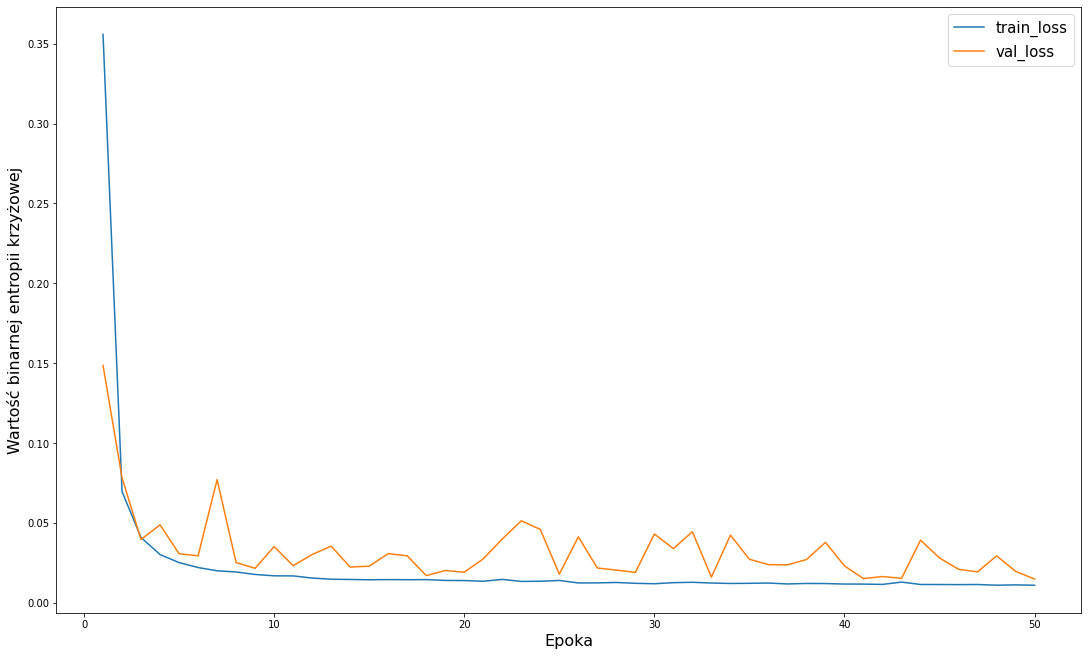

In [6]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(15, 9), constrained_layout=True)

ax.plot(epochs, logs['train_loss'])
ax.plot(epochs, logs['val_loss'])
ax.legend(["train_loss", "val_loss"], loc=0, prop={'size': 15})
ax.set_xlabel('Epoka', size=16)
ax.set_ylabel('Wartość binarnej entropii krzyżowej', size=16)

Text(0, 0.5, 'Wartość [%]')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


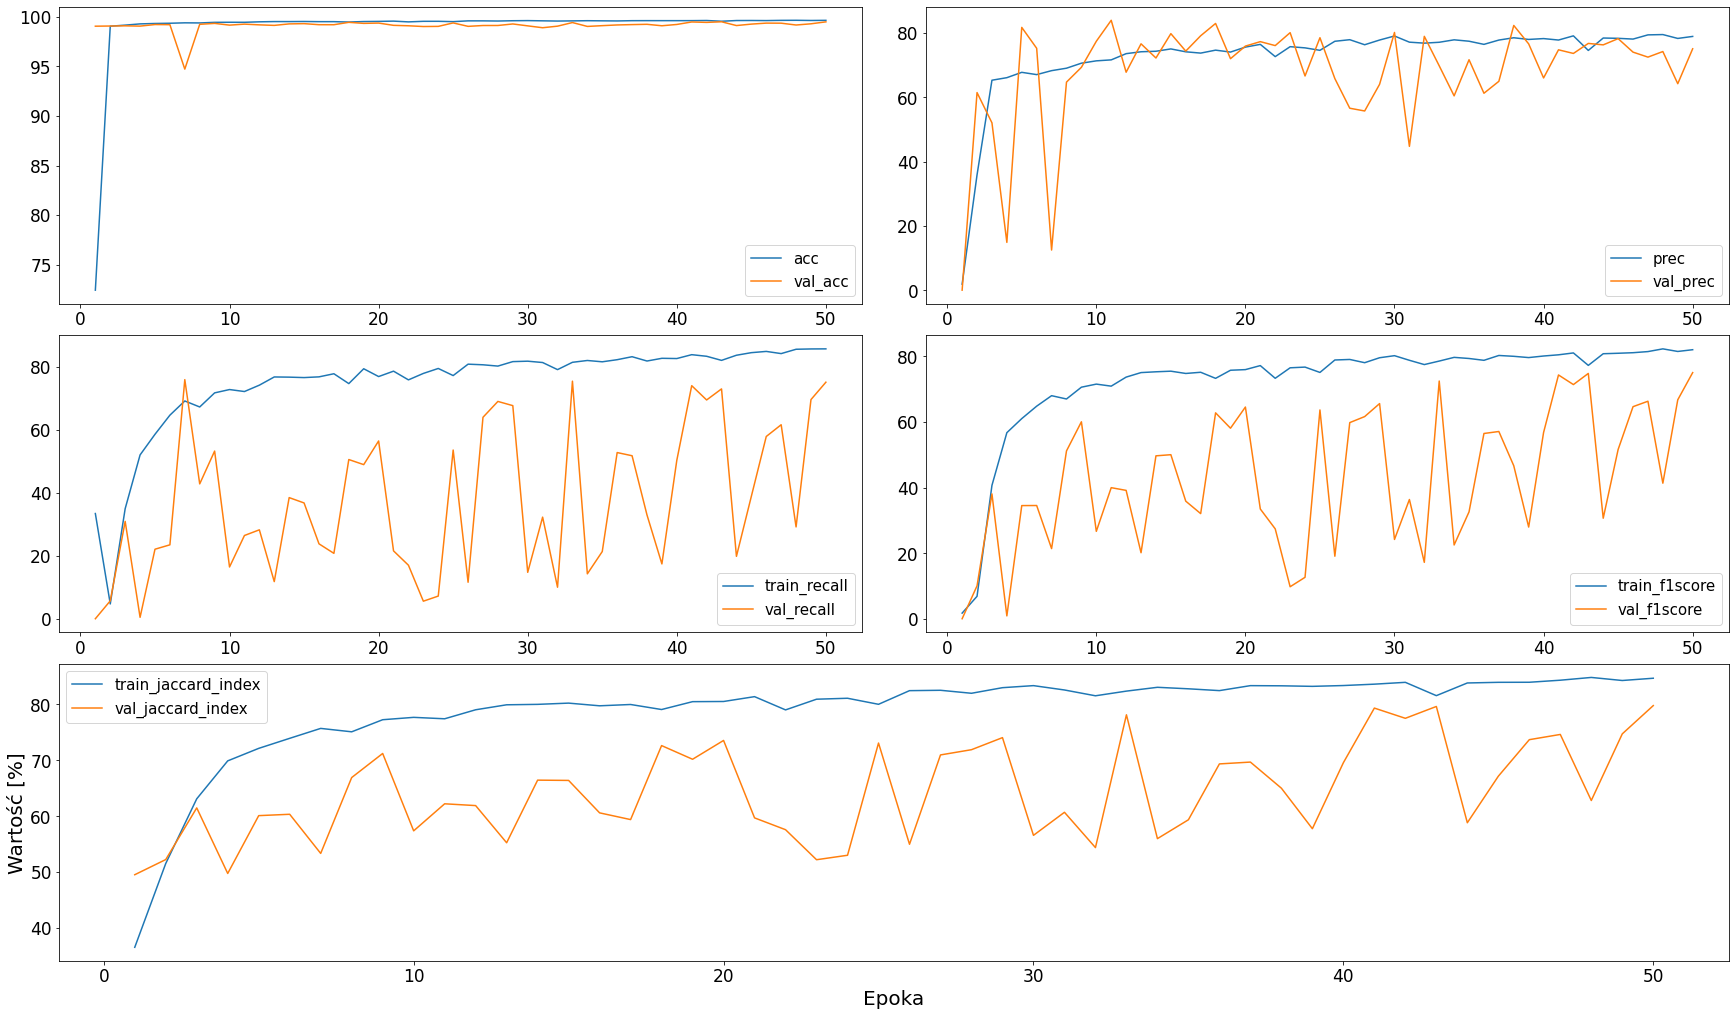

In [7]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(24, 14), constrained_layout=True)
spec = fig.add_gridspec(3, 2)
ax00 = fig.add_subplot(spec[0, 0])
ax01 = fig.add_subplot(spec[0, 1])
ax10 = fig.add_subplot(spec[1, 0], sharex=ax00)
ax11 = fig.add_subplot(spec[1, 1], sharex=ax01)
ax2 = fig.add_subplot(spec[2, :])
ax00.plot(epochs, logs['acc'])
ax00.plot(epochs, logs['val_acc'])
ax00.legend(['acc', 'val_acc'], loc=0, prop={'size': 15})
ax01.plot(epochs, logs['prec'])
ax01.plot(epochs, logs['val_prec'])
ax01.legend(['prec', 'val_prec'], loc=0, prop={'size': 15})
ax10.plot(epochs, logs['recall'])
ax10.plot(epochs, logs['val_recall'])
ax10.legend(['train_recall', 'val_recall'], loc=0, prop={'size': 15})
ax11.plot(epochs, logs['f1'])
ax11.plot(epochs, logs['val_f1'])
ax11.legend(['train_f1score', 'val_f1score'], loc=0, prop={'size': 15})
ax2.plot(epochs, logs['ji'])
ax2.plot(epochs, logs['val_ji'])
ax2.legend(['train_jaccard_index', 'val_jaccard_index'], loc=0, prop={'size': 15})
ax2.set_xlabel('Epoka', size=20)
ax2.set_ylabel('Wartość [%]', size=20)

In [2]:
batch_size = 1
num_workers = 4
train_size = 0.7
seed = 42
device = t.device('cuda')
dataset_root_path = "../datasets/brain/Brats2021_training_df/"

In [3]:
def __get_filenames_from_dir__(path:str):
    filenames = []
    for dir in Path(path).iterdir():
        filenames.append(dir)
    return filenames

test_size = 1 - train_size
filenames = __get_filenames_from_dir__(dataset_root_path)
train_names, val_names = train_test_split(filenames, test_size=test_size, random_state=seed)
val_names, test_names = train_test_split(val_names, test_size=0.5, random_state=seed)

# ======== LOAD DATA ===========
print("Loading datasets")
train_dataset = Brain3DDataset(train_names, scale=64)
val_dataset = Brain3DDataset(val_names, scale=64)
test_dataset = Brain3DDataset(test_names, scale=64)

train_loader = t.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
val_loader = t.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = t.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

img, label = next(iter(train_loader))
print("Shapes:")
print(f"Input img: {img.shape},  Label: {label.shape}")

Loading datasets
Shapes:
Input img: torch.Size([1, 4, 64, 64, 64]),  Label: torch.Size([1, 1, 64, 64, 64])


In [4]:
network = Unet3d(in_channels=4, out_channels=1).to(device)

In [5]:
network.load_state_dict(t.load('/mnt/e/mgr/trainings/model_states/seg_binary_3d/resnet34_64_64_64/model_state_best'))

<All keys matched successfully>

In [12]:
global_tp = 0.0
global_fp = 0.0
global_tn = 0.0
global_fn = 0.0
global_ji = 0.0

network.eval()
for i, (img, label) in enumerate(tqdm(test_loader)):
    img = img.to(device)
    label = label.to(device)
    with t.no_grad():
        output = network(img)
    output = nn.Sigmoid()(output)
    output = t.where(output >= 0.4, 1, output)
   
    tp, fp, tn, fn = calculate_type_errors(output.cpu(), label.cpu(), mode='segment_binary')
    ji = JaccardIndex(num_classes=2)(output.cpu(), label.type(t.int32).cpu()).item()
    
    global_ji += ji
    global_tp += tp
    global_fp += fp
    global_tn += tn
    global_fn += fn

recall, precision, acc, f1_score = calc_metrics(global_tp, global_fp, global_tn, global_fn)
print(f"Acc: {acc}, Recall: {recall}, F1score: {f1_score}, Precision: {precision}, IoU: {global_ji / (i+1)}")


100%|██████████| 188/188 [03:55<00:00,  1.26s/it]

Acc: 0.9959103465080261, Recall: 0.799190104007721, F1score: 0.7844187617301941, Precision: 0.7701836824417114, IoU: 0.7982209359711789


In [6]:
eval_network = network.enc.cpu()
eval_network.eval()

Encoder(
  (conv1): Conv3d(4, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=(2, 2, 2), padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): Conv3d(4, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): MaxPool3d(kernel_size=3, stride=(2, 2, 2), padding=1, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3

In [7]:
embeddings = []
t1ce_images = []
labels = []
for i, (img, label) in enumerate(tqdm(test_dataset)):
    with t.no_grad():
        output = eval_network(img.unsqueeze(0))
        output = output[-1]
        output = nn.AdaptiveAvgPool2d(output_size=(1, 1))(output)
        output = output.squeeze().numpy()
        output = output.reshape(1, -1)

    embeddings.append(output)
    t1ce_images.append(img[3].numpy())
    labels.append(label.numpy())

    del output

embeddings = np.array(embeddings)

100%|██████████| 188/188 [14:01<00:00,  4.47s/it]


In [14]:
embeddings = embeddings.squeeze()

/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 188 samples in 0.000s...
[t-SNE] Computed neighbors for 188 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 188 / 188
[t-SNE] Mean sigma: 1.655247
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.388863
[t-SNE] KL divergence after 750 iterations: 0.136686


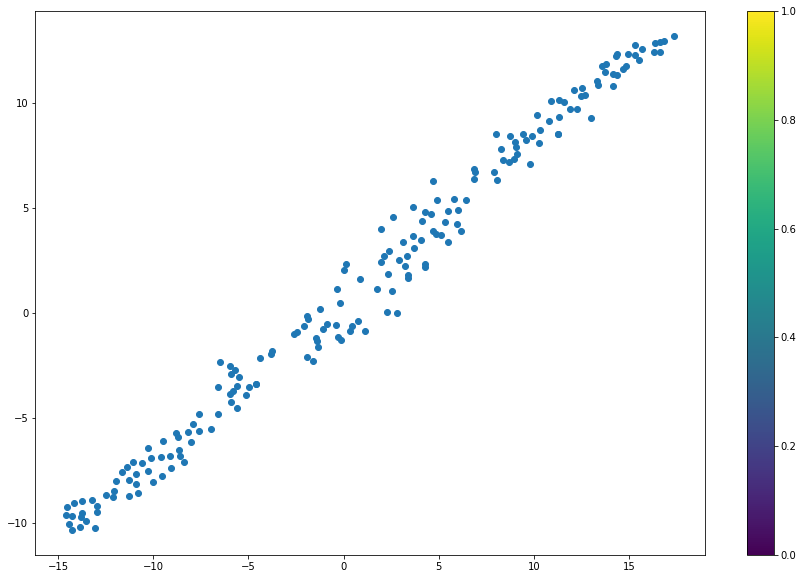

In [15]:
tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean', random_state=42).fit_transform(embeddings)
plt.figure(figsize=(15, 10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar()

In [22]:
def find_case(case_folder: str):
    sample = None
    seg = None
    for filename_path in case_folder.iterdir():
        if 't1ce' in filename_path.name:
            sample = nib.load(filename_path).get_fdata().copy()
        if 'seg' in filename_path.name:
            seg = nib.load(filename_path).get_fdata().copy()
            seg = np.where(seg >=1, 1, 0)

    return sample, seg

In [35]:
neighbors = NearestNeighbors(n_neighbors=len(embeddings), algorithm='brute', metric='euclidean').fit(embeddings)
distances, indices = neighbors.kneighbors([embeddings[180]])
indices = indices.flatten()

k_nearest = indices[0:5]
nearest_dist = distances.flatten()[0:5]
k_furthest = indices[-5:][::-1]
furthest_dist = distances.flatten()[-5:][::-1]

In [36]:
simillar_images = [find_case(test_names[idx]) for idx in k_nearest]
no_simillar_images = [find_case(test_names[idx]) for idx in k_furthest]
simillar_max_slice = [get_max_area_slice(find_case(test_names[idx])[1]) for idx in k_nearest]
no_simillar_max_slice = [get_max_area_slice(find_case(test_names[idx])[1]) for idx in k_furthest]

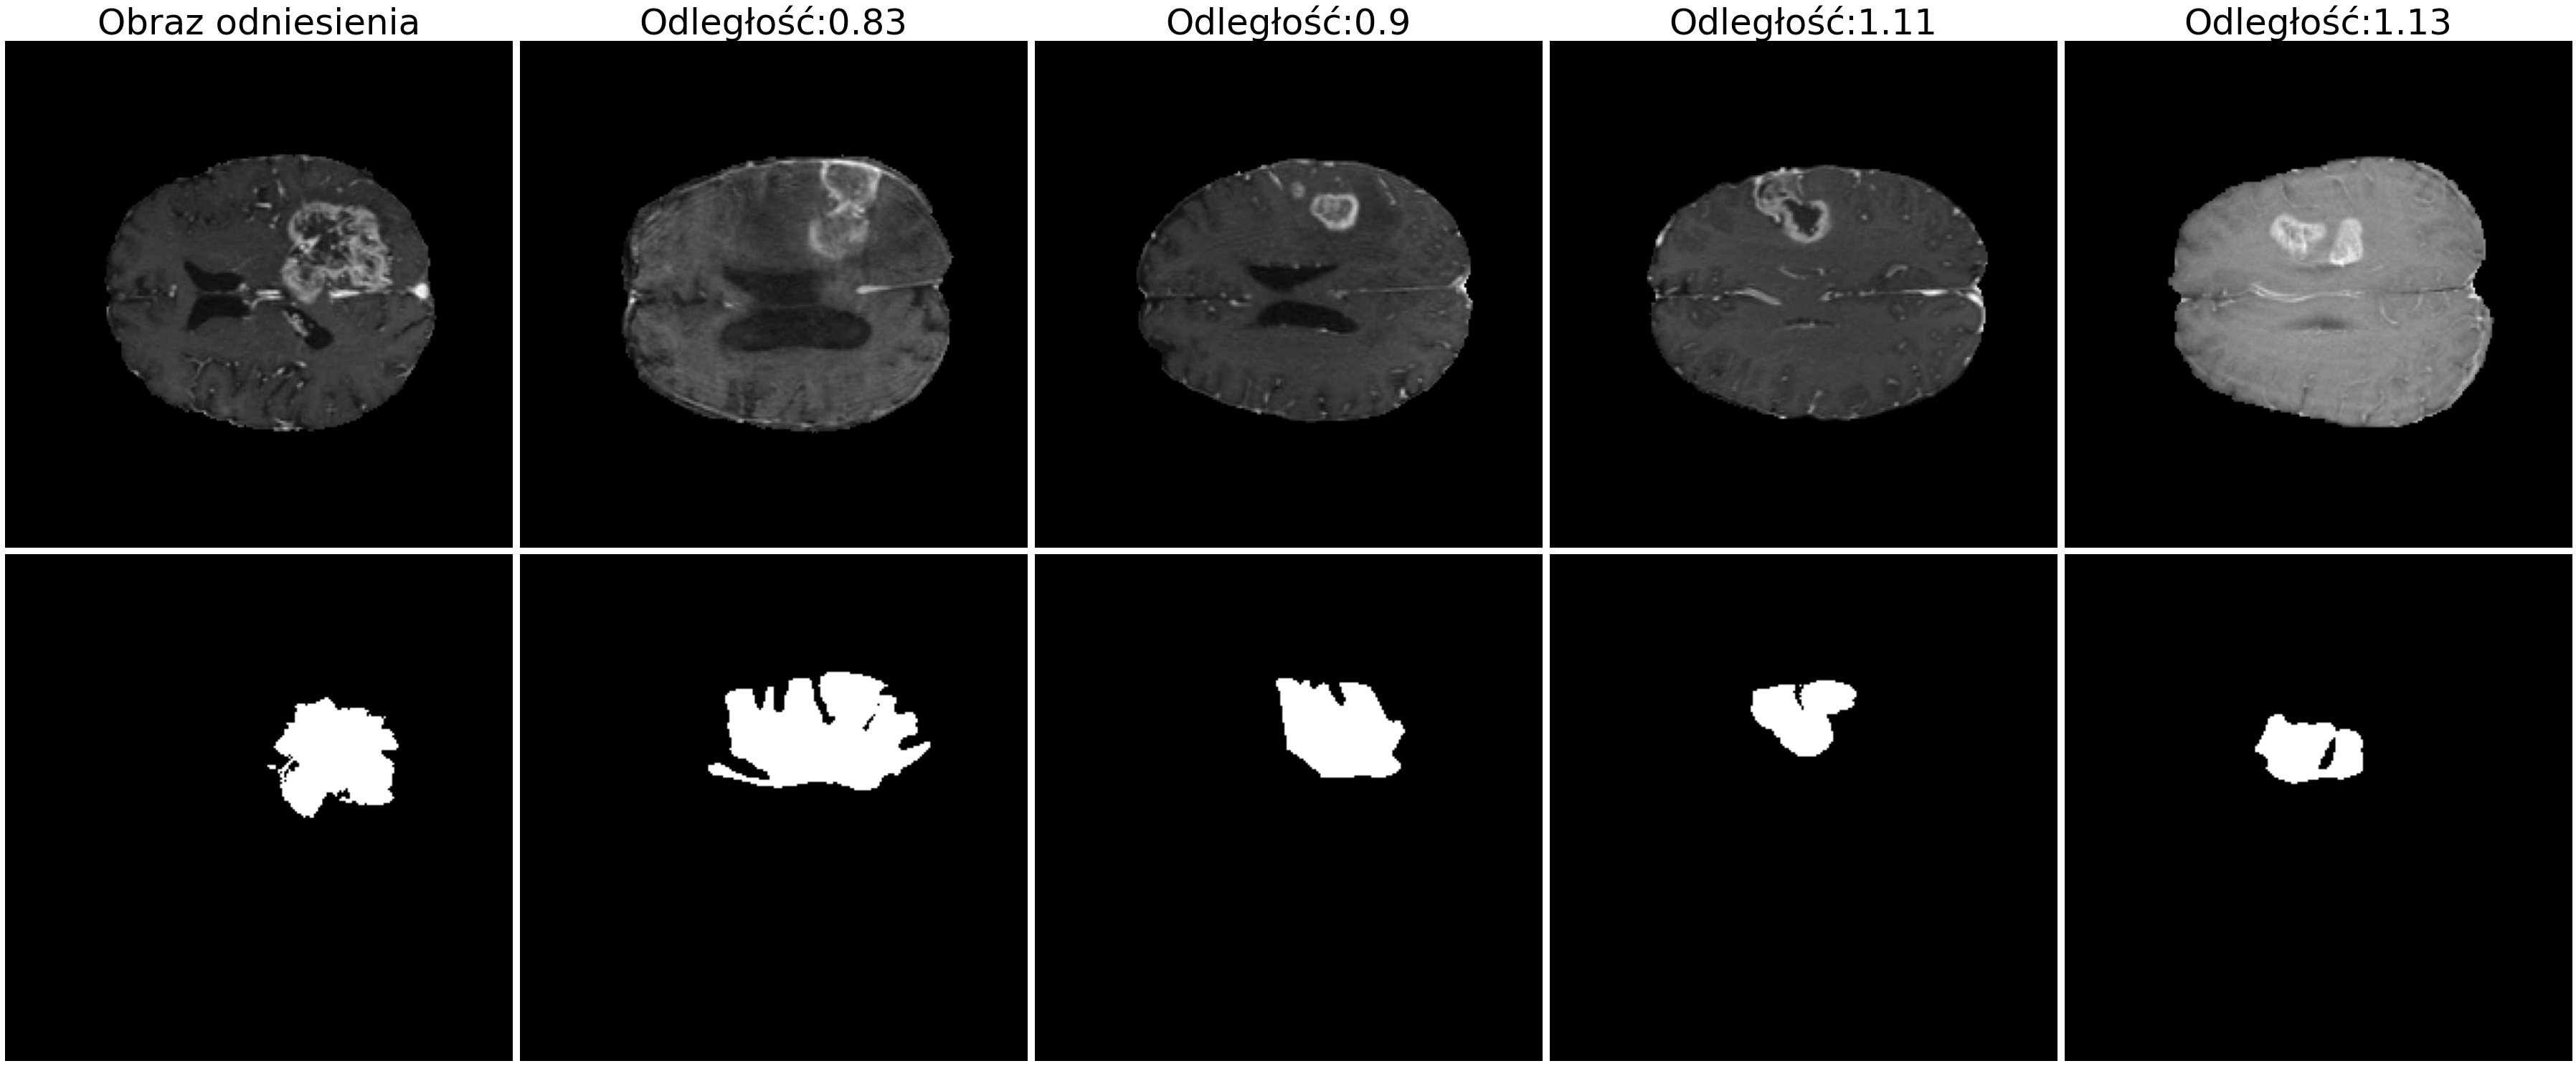

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(50, 21))
for i, idx in enumerate(k_nearest):
    ax[0, i].imshow(simillar_images[i][0][:, :, simillar_max_slice[i]], cmap='gray')
    ax[1, i].imshow(simillar_images[i][1][:, :, simillar_max_slice[i]], cmap='gray')
    ax[0, i].set_title(f'Odległość:{round(nearest_dist.tolist()[i], 2)}', size=50)
    ax[0, i].axis('off')
    ax[1, i].axis('off')
ax[0, 0].set_title('Obraz odniesienia', size=50)
fig.tight_layout()

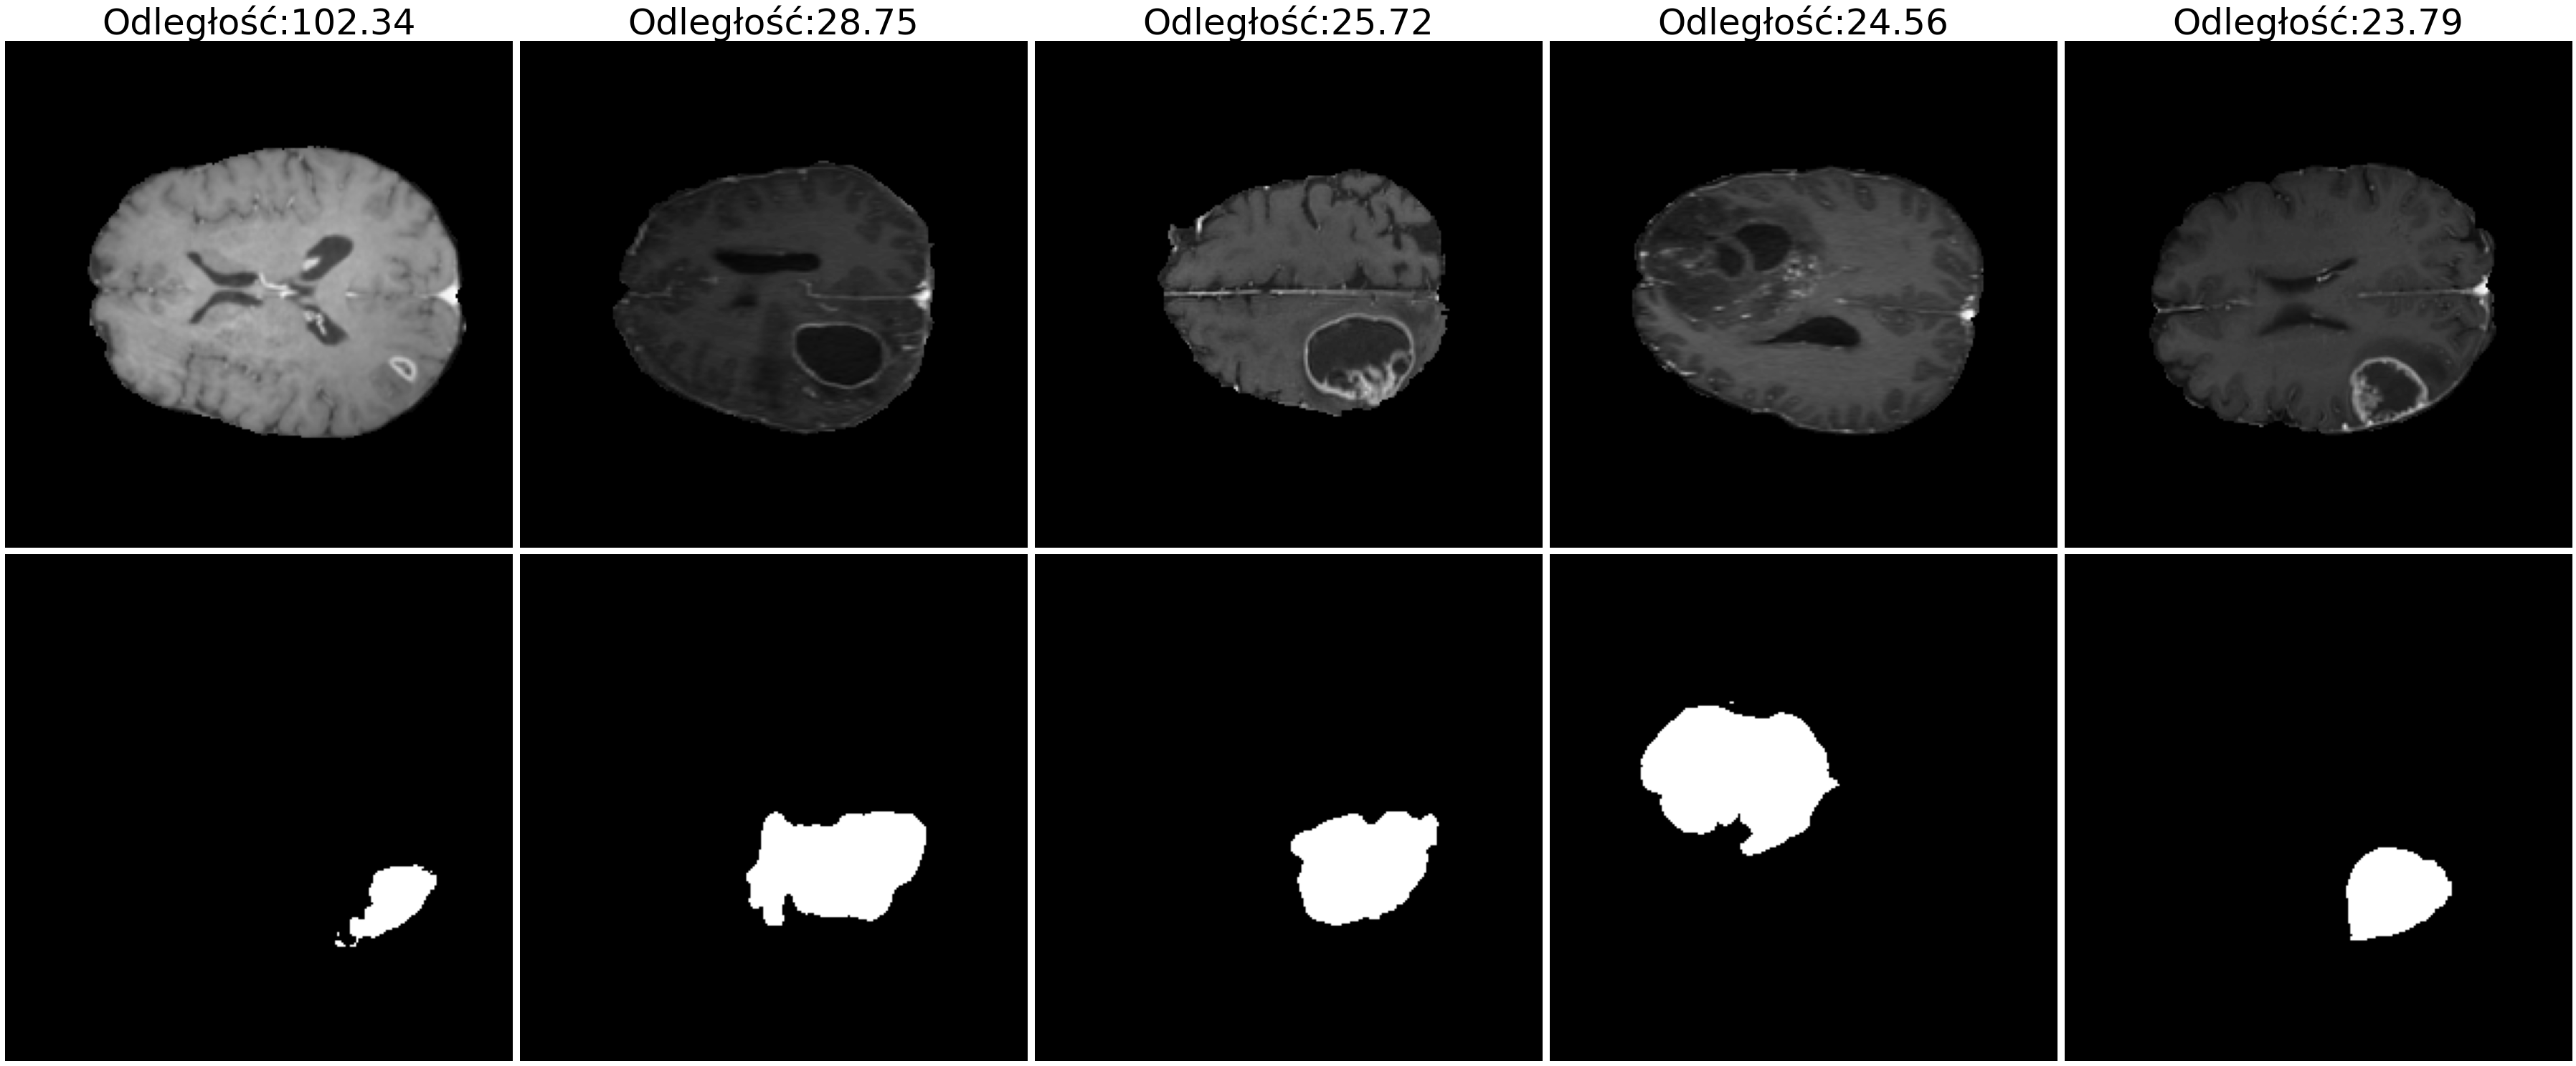

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(50, 21))
for i, idx in enumerate(k_furthest):
    ax[0, i].imshow(no_simillar_images[i][0][:, :, no_simillar_max_slice[i]], cmap='gray')
    ax[1, i].imshow(no_simillar_images[i][1][:, :, no_simillar_max_slice[i]], cmap='gray')
    ax[0, i].set_title(f'Odległość:{round(furthest_dist.tolist()[i], 2)}', size=50)
    ax[0, i].axis('off')
    ax[1, i].axis('off')
fig.tight_layout()